# Data Extraction Notebook for :Savings from a battery and solar system during ERCOT 4CP events

## This notebook will connect to the database and extract the data live and put it into compressed zip files in this directory. 

We're going to look at if solar equipped homes stored all excess energy produced on the day of a 4CP event between 7AM until 4PM, then started discharging it from 4-5:30PM. How much energy would be stored up, and what would the potential savings of that be based on a cost of $55/kWh.

<p>You'll need to modify the read_csv calls in that notebook to point at these instead of the ones we've extracted and prepared for you in the /shared/JupyterHub-Examples-Data/ directory on the JupyterHub server if you would like to use the ones exported by this notebook in the analysis notebook.</p>

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy as sqla
import os
import sys
sys.path.insert(0,'..')
from config.read_config import get_database_config
sys.executable  # shows you your path to the python you're using

'/opt/conda/bin/python'

In [2]:
# read in db credentials from config/config.txt
# * make sure you add those to the config/config.txt file! *

database_config = get_database_config("../config/config.txt")


In [3]:
# get our DB connection
engine = sqla.create_engine('postgresql://{}:{}@{}:{}/{}'.format(database_config['username'],
                                                                     database_config['password'],
                                                                     database_config['hostname'],
                                                                     database_config['port'],
                                                                     database_config['database']
                                                                     ))


In [4]:
# Set the cost of a kWh in dollars
cost_kWh = 55

# These are the ERCOT 4CP events (start date/time and end date/time) for 2016 - 2019 acquired from
# http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13037&reportTitle=Planned%20Service%20Four%20Coincident%20Peak%20Calculations&showHTMLView=&mimicKey

event_days = ['2019-06-19', '2019-07-30', '2019-08-12', '2019-09-06',
               '2018-06-27', '2018-07-19', '2018-08-23', '2018-09-19',
               '2017-06-23', '2017-07-28', '2017-08-16', '2017-09-20',
               '2016-06-15', '2016-07-14', '2016-08-11', '2016-09-19'
              ]

# we're going to look at using 7AM to 4PM to charge the theoretical battery as the time the sun becomes available to the PV systems 
# until the earliest possible time of a 4CP event (4PM), then discharge from 4PM - 5:30PM to cover any 4CP timeslots that have happened thus far
start_time = '07:00:00-05'
end_time   = '16:00:00-05'

# these are the actual 4CP event start times and end times from 2016-2019 for reference
event_start_dates = ['2019-06-19 17:00:00-05', '2019-07-30 16:30:00-05', '2019-08-12 17:00:00-05', '2019-09-06 16:45:00-05',
               '2018-06-27 17:00:00-05', '2018-07-19 17:00:00-05', '2018-08-23 16:45:00-05', '2018-09-19 16:30:00-05',
               '2017-06-23 16:45:00-05', '2017-07-28 17:00:00-05', '2017-08-16 17:00:00-05', '2017-09-20 16:45:00-05',
               '2016-06-15 17:00:00-05', '2016-07-14 16:00:00-05', '2016-08-11 16:30:00-05', '2016-09-19 16:15:00-05'
              ]
event_end_dates = ['2019-06-19 17:15:00-05', '2019-07-30 16:45:00-05', '2019-08-12 17:15:00-05', '2019-09-06 17:00:00-05',
               '2018-06-27 17:15:00-05', '2018-07-19 17:15:00-05', '2018-08-23 17:00:00-05', '2018-09-19 16:45:00-05',
               '2017-06-23 17:00:00-05', '2017-07-28 17:15:00-05', '2017-08-16 17:15:00-05', '2017-09-20 17:00:00-05',
               '2016-06-15 17:15:00-05', '2016-07-14 16:15:00-05', '2016-08-11 16:45:00-05', '2016-09-19 16:30:00-05'
                  ]

In [5]:
# let's select homes that have solar and a high amount of data completeness
# we're also filtering out homes that have really large solar arrays (larger than 6.25)
# we're excluding dataids 5448, 2925 due to having a battery already
query = """
select dataid, pv, total_amount_of_pv
from other_datasets.metadata
where pv is not null
and grid is not null 
and solar is not null
and total_amount_of_pv is not null
and total_amount_of_pv <= 6.25
and egauge_1min_min_time < '2016-06-15'
and egauge_1min_max_time > '2019-09-06'
and dataid not in (5448, 2925)
and (egauge_1min_data_availability like '%100%' or egauge_1min_data_availability like '99%' or egauge_1min_data_availability like '98%')
limit 25
"""

# create a Pandas dataframe with the data from the sql query
dataids = pd.read_sql_query(sqla.text(query), engine)
dataids.head(10)

,dataid,pv,total_amount_of_pv
0,7030,yes,5.250
1,5738,yes,5.920
2,4357,yes,4.000
3,7016,yes,6.105
4,1792,yes,6.250
5,545,yes,3.150
6,114,yes,3.500
7,5749,yes,3.200
8,3310,yes,6.125
9,6691,yes,5.200


In [6]:
dataids.describe()

,dataid,total_amount_of_pv
count,25.000000,25.000000
mean,5838.760000,5.247280
std,2653.709248,1.011685
min,114.000000,3.150000
25%,3829.000000,4.500000
50%,6691.000000,5.712000
75%,7739.000000,6.000000
max,9971.000000,6.250000


In [7]:
# extract the dataids
# grab dataids and convert them to a string to put into the SQL query
dataids_list = dataids['dataid'].tolist()
print("{} dataids selected listed here:".format(len(dataids_list)))
dataids_str = ','.join(list(map(str, dataids_list)))
dataids_str
# dataids_list

25 dataids selected listed here:


'7030,5738,4357,7016,1792,545,114,5749,3310,6691,3368,7875,9776,3506,8645,7017,5109,3829,6121,8086,9971,7850,7739,7627,7108'

In [8]:
# select the data for all of the events for all of these homes starting at 7AM and ending at 4PM
# the first date starting at midnight and ending at the end time of one of the 4CP events

first_start = event_days.pop(0)
energy_query = """
select dataid, localminute, solar, grid from electricity.eg_realpower_1min 
where ((localminute >= '{} {}' and localminute <= '{} {}') """.format(first_start, start_time, first_start, end_time)

for day in event_days:
    energy_query = energy_query + "OR (localminute >= '{} {}' and localminute <= '{} {}') ".format(day, start_time, day, end_time)

energy_query = energy_query + """ ) AND dataid in ({})""".format(dataids_str)

print("query is {}".format(energy_query))

df2 = pd.read_sql_query(sqla.text(energy_query), engine)

query is 
select dataid, localminute, solar, grid from electricity.eg_realpower_1min 
where ((localminute >= '2019-06-19 07:00:00-05' and localminute <= '2019-06-19 16:00:00-05') OR (localminute >= '2019-07-30 07:00:00-05' and localminute <= '2019-07-30 16:00:00-05') OR (localminute >= '2019-08-12 07:00:00-05' and localminute <= '2019-08-12 16:00:00-05') OR (localminute >= '2019-09-06 07:00:00-05' and localminute <= '2019-09-06 16:00:00-05') OR (localminute >= '2018-06-27 07:00:00-05' and localminute <= '2018-06-27 16:00:00-05') OR (localminute >= '2018-07-19 07:00:00-05' and localminute <= '2018-07-19 16:00:00-05') OR (localminute >= '2018-08-23 07:00:00-05' and localminute <= '2018-08-23 16:00:00-05') OR (localminute >= '2018-09-19 07:00:00-05' and localminute <= '2018-09-19 16:00:00-05') OR (localminute >= '2017-06-23 07:00:00-05' and localminute <= '2017-06-23 16:00:00-05') OR (localminute >= '2017-07-28 07:00:00-05' and localminute <= '2017-07-28 16:00:00-05') OR (localminute >= '

In [9]:
df2.describe()

,dataid,solar,grid
count,214371.000000,208300.000000,205595.000000
mean,5852.952377,2.090170,-0.089951
std,2603.123636,1.465602,2.371499
min,114.000000,-0.076000,-6.100000
25%,3829.000000,0.686000,-1.747000
50%,6691.000000,2.142000,-0.130000
75%,7739.000000,3.294000,0.948000
max,9971.000000,8.377000,20.753000


In [10]:
# calculate usage as grid minus solar (which is actually grid + solar because solar is negative use)
# Calculate the difference with a lambda function and add it as a new column called 'usage'

# NOTE: This takes a while to run, after all it's running this lambda function on ~520k points
df2['usage'] = df2.apply(lambda row: row.solar + row.grid, axis=1)
df2.describe()

,dataid,solar,grid,usage
count,214371.000000,208300.000000,205595.000000,205595.000000
mean,5852.952377,2.090170,-0.089951,1.968155
std,2603.123636,1.465602,2.371499,2.307413
min,114.000000,-0.076000,-6.100000,0.002000
25%,3829.000000,0.686000,-1.747000,0.336000
50%,6691.000000,2.142000,-0.130000,0.817000
75%,7739.000000,3.294000,0.948000,3.306000
max,9971.000000,8.377000,20.753000,27.363000


In [11]:
# export homes to csv file
compression_opts = dict(method='zip',
                        archive_name='pv_storage_savings.zip')
df2.to_csv('pv_storage_savings.zip', index=False,
          compression=compression_opts)

In [12]:
# convert localminute to pandas datetime type
df2['datetime'] = pd.to_datetime(df2['localminute'])

# and set as index
df2 = df2.set_index('datetime')

# set local timezone
df2 = df2.tz_convert('US/Central')

df2

,dataid,localminute,solar,grid,usage
datetime,,,,,
2016-06-15 07:00:00-05:00,4357,2016-06-15 12:00:00+00:00,0.027,0.057,0.084
2016-06-15 07:01:00-05:00,4357,2016-06-15 12:01:00+00:00,0.031,0.052,0.083
2016-06-15 07:02:00-05:00,4357,2016-06-15 12:02:00+00:00,0.035,0.048,0.083
2016-06-15 07:03:00-05:00,4357,2016-06-15 12:03:00+00:00,0.039,0.044,0.083
2016-06-15 07:04:00-05:00,4357,2016-06-15 12:04:00+00:00,0.044,0.039,0.083
...,...,...,...,...,...
2019-09-06 16:00:00-05:00,6691,2019-09-06 21:00:00+00:00,2.522,2.633,5.155
2019-09-06 16:00:00-05:00,9971,2019-09-06 21:00:00+00:00,3.666,-3.377,0.289
2019-09-06 16:00:00-05:00,114,2019-09-06 21:00:00+00:00,1.874,1.208,3.082


In [13]:

# group by month and dataid and sum negative grid grouping into month by dataid giving us each home's accumulated negative grid 
# (extra solar production) for that month's 4CP event day between 7AM and 4PM
df3 = df2.loc[df2['grid'] < 0].groupby([pd.Grouper(freq='M'), 'dataid']).sum()
df3

solar      grid    usage
datetime                  dataid                             
2016-06-30 00:00:00-05:00 114      735.877  -616.355  119.522
                          545      553.886  -381.549  172.337
                          1792     977.769  -495.488  482.281
                          3310    1045.621  -642.631  402.990
                          3368    1304.758 -1066.591  238.167
...                                    ...       ...      ...
2019-09-30 00:00:00-05:00 7875     707.793  -245.968  461.825
                          8086     448.896  -364.738   84.158
                          8645    1101.244  -799.236  302.008
                          9776     586.117  -147.639  438.478
                          9971    1165.505 -1005.654  159.851

[371 rows x 3 columns]

In [14]:
# we're going to have a look at what happens when we average them all together by month 
df4 = df3.reset_index()
df4 = df4.set_index('datetime')
df4 = df4.groupby([pd.Grouper(freq='M')]).mean()

# drop all rows that are all NaN
df4 = df4.dropna(thresh=3)

# drop all the dataids
df4 = df4.drop(columns=['dataid'])

# convert to KWh
df4 = df4.apply(lambda x : x / 60.0)

# this gives us the 16 event days averaged together per day
df4

,solar,grid,usage
datetime,,,
2016-06-30 00:00:00-05:00,13.775994,-9.245455,4.530539
2016-07-31 00:00:00-05:00,13.155441,-8.815152,4.340289
2016-08-31 00:00:00-05:00,10.705781,-7.060321,3.645460
2016-09-30 00:00:00-05:00,13.452518,-9.255737,4.196781
2017-06-30 00:00:00-05:00,12.998646,-9.550308,3.448338
2017-07-31 00:00:00-05:00,12.983257,-9.474882,3.508375
2017-08-31 00:00:00-05:00,13.613569,-9.303267,4.310302
2017-09-30 00:00:00-05:00,12.441833,-8.967725,3.474107
2018-06-30 00:00:00-05:00,12.588280,-8.990298,3.597982


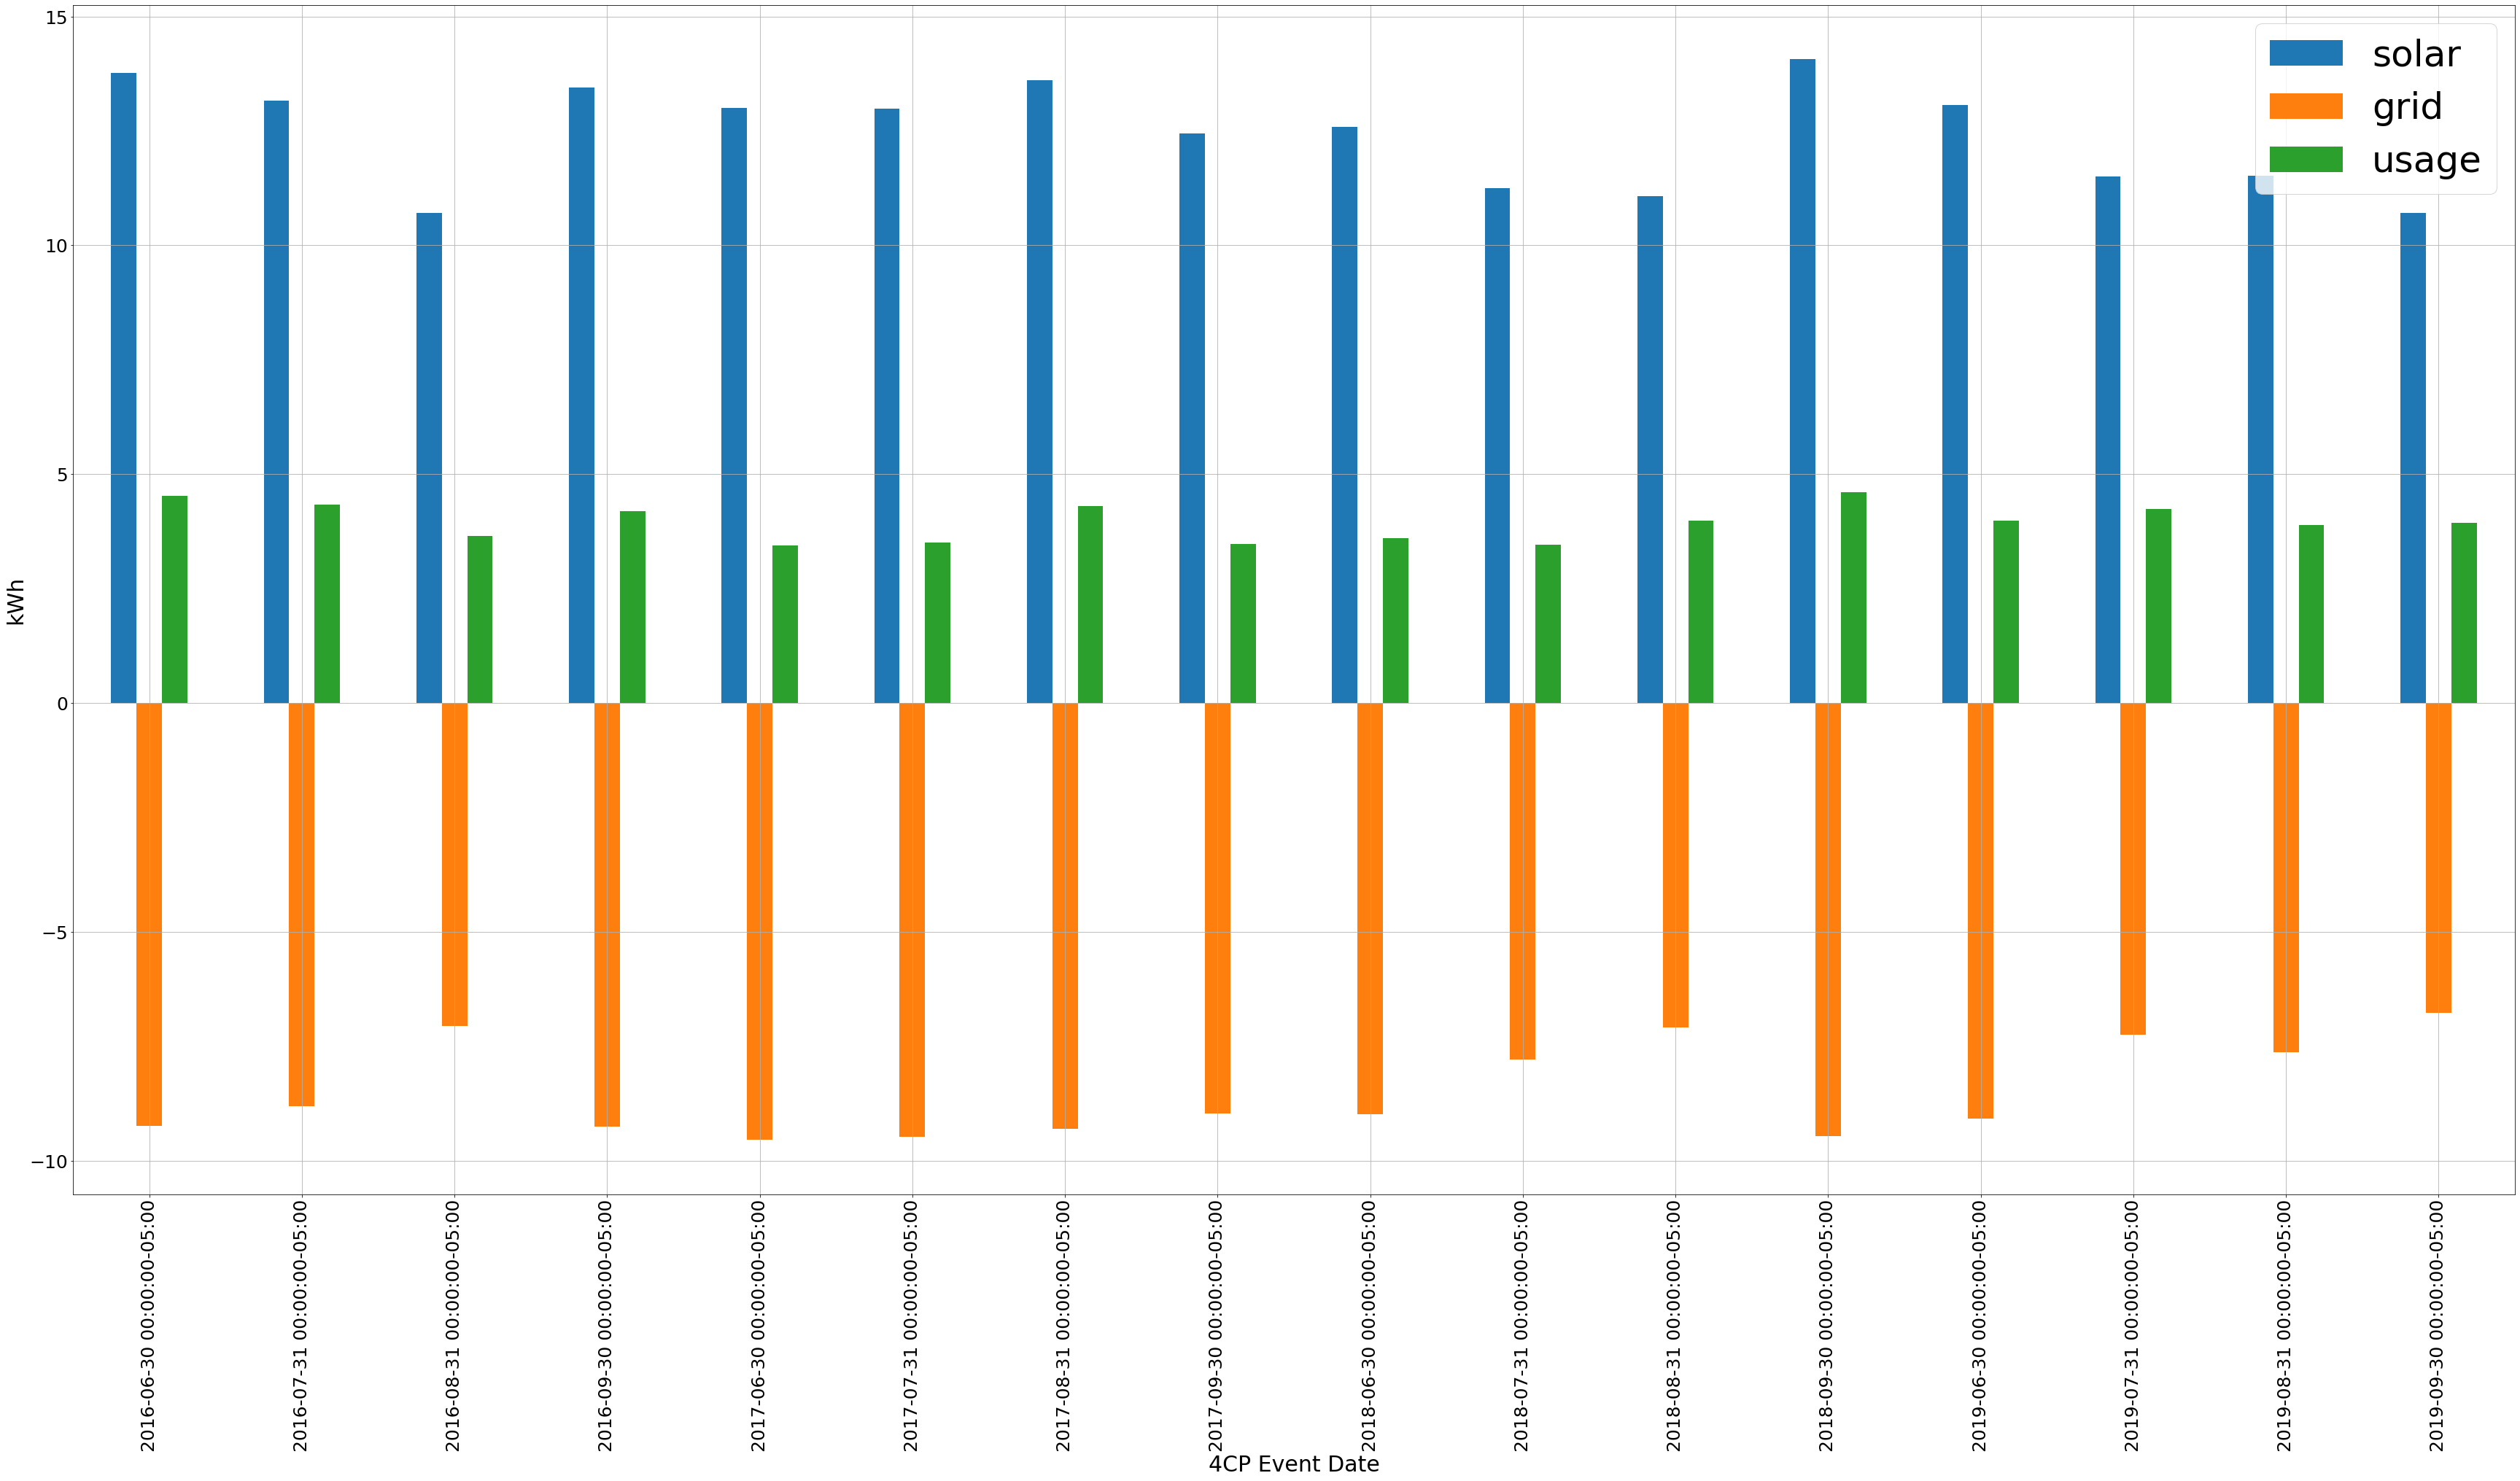

In [15]:
# let's put this all on a bar chart with a set of solar/grid/usage per day
ax = df4.plot.bar(rot=90, figsize=[60,30], fontsize=25, grid=True)
ax.set_xlabel('4CP Event Date', fontsize = 30)
ax.set_ylabel('kWh', fontsize = 30)
legend = ax.legend(loc=1, prop={'size': 50})

In [16]:
# OK, back to the 3rd dataframe before we averaged them all together by month when we simply had grouped by month and dataid 
# and taken a sum of the rows with negative grid

# let's drop the usage and solar columns now that we'll only be working with the grid column
df3 = df3.drop(columns=['solar','usage'])
df3.describe()

,grid
count,371.000000
mean,-509.678216
std,366.016941
min,-1866.704000
25%,-756.619500
50%,-495.070000
75%,-188.462000
max,-0.070000


In [17]:
# average that entire negative grid column
ave_neg = df3.mean()
ave_neg.grid

-509.67821563342306

In [18]:
# convert summed up usage to give us kWh by dividing by 60 (one minute data / 60 because there are 60 minutes per hour)
kWh = ave_neg.grid / 60
kWh

-8.494636927223718

In [19]:
# divide by 1.5 to calculate the kW discharged over the 1.5 hours of the time between 4PM and 5:30PM to cover the potential 4CP event.
kW = kWh / 1.5
kW

-5.663091284815812

In [20]:
# At a rate of $550 / kW how much on average is saved per house if we store up all the solar produced starting at 
# 7AM until 4PM and then discharge to cover the potential 4CP event that day from 4PM - 5:30 PM
value = abs(kW) * cost_kWh
print("Average $ saved per house if they charged their battery day of a 4CP event, then started discharging at 4PM would be ${}".format(str(round(value, 2))))

Average $ saved per house if they charged their battery day of a 4CP event, then started discharging at 4PM would be $311.47
